# Read Data Sample

In [1]:
import pandas as pd
import numpy as np
import os
from collections import namedtuple
pd.set_option("display.max_rows",100)
%matplotlib inline

In [2]:
%%bash
rm dataset/scores/tf_dense_only_nsl_kdd_scores_all.pkl

rm: cannot remove 'dataset/scores/tf_dense_only_nsl_kdd_scores_all.pkl': No such file or directory


In [3]:
class preprocess:
    
    paths = {}

    def get_files(folder_path):
        paths = {}
        for path, subdirs, files in os.walk(folder_path):
            for name in files:
                if name.endswith("csv"):
                    key = name.split("_")[0]

                    if paths.get(key) is None:
                        paths[key] = {}

                    if name.endswith("_x.csv"):
                        x = os.path.join(path, name)
                        paths[key]['x'] = x
                    elif name.endswith("_y.csv"):
                        y = os.path.join(path, name)
                        paths[key]['y'] = y
        preprocess.paths = paths
        return paths

    def get_data(paths):
        for key, value in paths.items():
            x = pd.read_csv(value['x'])
            y = pd.read_csv(value['y'])
            #print(x.shape)
            #print(x.values.shape)
            #print(y.sum())
            yield key, x.values, y.values
        
        
    
    
train_paths = preprocess.get_files("dataset/Kyoto2016/2014/01")
test_paths = preprocess.get_files("dataset/Kyoto2016/2015/12")
#test_paths.update(preprocess.get_files("dataset/Kyoto2016/2015/11"))
#test_paths.update(preprocess.get_files("dataset/Kyoto2016/2015/10"))


paths = {}
keys = train_paths.keys()
for key in list(keys)[0:7]:
    paths.update({key: train_paths[key]})
train_paths = paths

print(train_paths)
print("----------------------------------------------------------------------------------------")
#test_paths = test_paths.popitem()
#test_paths = {test_paths[0]: test_paths[1]}
print(test_paths)


{'20140115': {'x': 'dataset/Kyoto2016/2014/01/20140115_x.csv', 'y': 'dataset/Kyoto2016/2014/01/20140115_y.csv'}, '20140107': {'y': 'dataset/Kyoto2016/2014/01/20140107_y.csv', 'x': 'dataset/Kyoto2016/2014/01/20140107_x.csv'}, '20140109': {'x': 'dataset/Kyoto2016/2014/01/20140109_x.csv', 'y': 'dataset/Kyoto2016/2014/01/20140109_y.csv'}, '20140104': {'y': 'dataset/Kyoto2016/2014/01/20140104_y.csv', 'x': 'dataset/Kyoto2016/2014/01/20140104_x.csv'}, '20140119': {'x': 'dataset/Kyoto2016/2014/01/20140119_x.csv', 'y': 'dataset/Kyoto2016/2014/01/20140119_y.csv'}, '20140120': {'x': 'dataset/Kyoto2016/2014/01/20140120_x.csv', 'y': 'dataset/Kyoto2016/2014/01/20140120_y.csv'}, '20140123': {'x': 'dataset/Kyoto2016/2014/01/20140123_x.csv', 'y': 'dataset/Kyoto2016/2014/01/20140123_y.csv'}, '20140118': {'x': 'dataset/Kyoto2016/2014/01/20140118_x.csv', 'y': 'dataset/Kyoto2016/2014/01/20140118_y.csv'}, '20140108': {'x': 'dataset/Kyoto2016/2014/01/20140108_x.csv', 'y': 'dataset/Kyoto2016/2014/01/20140108_

In [4]:
import tensorflow as tf


In [5]:
class network(object):
    
    input_dim = 42
    classes = 2
    hidden_encoder_dim = 42
    hidden_layers = 1
    latent_dim = 18

    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        input_dim = self.input_dim
        classes = self.classes
        hidden_encoder_dim = self.hidden_encoder_dim
        hidden_layers = self.hidden_layers
        latent_dim = self.latent_dim
        
        with tf.variable_scope("Input"):
            self.x = tf.placeholder("float", shape=[None, input_dim])
            self.y_ = tf.placeholder("float", shape=[None, classes])
            self.keep_prob = tf.placeholder("float")
            self.lr = tf.placeholder("float")
        
        with tf.variable_scope("Layer_Encoder"):

            hidden_encoder = tf.layers.dense(self.x, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            
            #hidden_encoder = tf.layers.dense(self.x, latent_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            #hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            
        with tf.variable_scope("Layer_Dense_Softmax"):
            self.y = tf.layers.dense(hidden_encoder, classes, activation=tf.nn.softmax)
            
        with tf.variable_scope("Loss"):
            
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = self.y_, logits = self.y))
            #loss = tf.losses.mean_squared_error(labels = self.y_, predictions = self.y)
            #loss = tf.clip_by_value(loss, -1e-1, 1e-1)
            #loss = tf.where(tf.is_nan(loss), 1e-1, loss)
            #loss = tf.where(tf.equal(loss, -1e-1), tf.random_normal(loss.shape), loss)
            #loss = tf.where(tf.equal(loss, 1e-1), tf.random_normal(loss.shape), loss)
            
            self.regularized_loss = loss
            correct_prediction = tf.equal(tf.argmax(self.y_, 1), tf.argmax(self.y, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")
            
        with tf.variable_scope("Optimizer"):
            learning_rate=self.lr
            optimizer = tf.train.AdamOptimizer(learning_rate)
            gradients, variables = zip(*optimizer.compute_gradients(self.regularized_loss))
            gradients = [
                None if gradient is None else tf.clip_by_value(gradient, -1, 1)
                for gradient in gradients]
            self.train_op = optimizer.apply_gradients(zip(gradients, variables))
            #self.train_op = optimizer.minimize(self.regularized_loss)
            
        # add op for merging summary
        #self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(self.y, axis = 1)
        self.actual = tf.argmax(self.y_, axis = 1)

        # add Saver ops
        self.saver = tf.train.Saver()
        

In [6]:
import collections
import time
from sklearn import model_selection as ms
from sklearn import metrics as me

class Train:    
    
    result = namedtuple("score", ['key', 'no_of_features','hidden_layers','train_score', 'test_score', 'quality_score', 'time_taken'])

    predictions = {}
    results = []
    
    best_acc = 0
    best_acc_global = 0
    
    def train(epochs, net, h,f, lrs):
        batch_iterations = 1000
        train_loss = None
        Train.best_acc = 0
        os.makedirs("dataset/tf_dense_only_nsl_kdd/hidden layers_{}_features count_{}".format(epochs,h,f),
                    exist_ok = True)
        with tf.Session() as sess:
            #summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            #summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())
            start_time = time.perf_counter()
            for c, lr in enumerate(lrs):
                for epoch in range(1, (epochs+1)):
                    
                    for key, x_train, y_train in preprocess.get_data(train_paths):
                        x_train, x_valid, y_train, y_valid, = ms.train_test_split(x_train, 
                                                                                  y_train, 
                                                                                  test_size=0.1)
                        batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                                   batch_iterations)

                        for i in batch_indices:

                            def train_batch():
                                nonlocal train_loss
                                _, train_loss = sess.run([net.train_op, 
                                                                   net.regularized_loss, 
                                                                   ], #net.summary_op
                                                                  feed_dict={net.x: x_train[i,:], 
                                                                             net.y_: y_train[i,:], 
                                                                             net.keep_prob:0.5, net.lr:lr})

                            train_batch()
                            #summary_writer_train.add_summary(summary_str, epoch)
                            #print("Step {} | Training Loss: {:.6f}".format(epoch, train_loss))
                            while((train_loss > 1e4 or np.isnan(train_loss)) and epoch > 1):
                                print("Step {} | Training Loss: {:.6f}".format(epoch, train_loss))
                                net.saver.restore(sess, 
                                                  tf.train.latest_checkpoint('dataset/tf_dense_only_nsl_kdd/hidden_layers_{}_features_count_{}'
                                                                             .format(epochs,h,f)))
                                train_batch()


                        valid_accuracy = sess.run(net.regularized_loss, #net.summary_op 
                                                              feed_dict={net.x: x_valid, 
                                                                         net.y_: y_valid, 
                                                                         net.keep_prob:1, net.lr:lr})
                        #summary_writer_valid.add_summary(summary_str, epoch)
                    
                        print("Key {} | Training Loss: {:.6f} | Validation Loss: {:.6f}".format(key, train_loss, valid_accuracy))
                    
                    end_time = time.perf_counter() 
                    for key, x_test, y_test in preprocess.get_data(test_paths):
                        accuracy, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, 
                                                                               net.pred, 
                                                                               net.actual, net.y], 
                                                                              feed_dict={net.x: x_test, 
                                                                                         net.y_: y_test, 
                                                                                         net.keep_prob:1, net.lr:lr})
                        
                        
                        q_score = me.matthews_corrcoef(actual_value, pred_value)
                        recall = me.recall_score(actual_value, pred_value)
                        prec = me.precision_score(actual_value, pred_value)
                        accuracy = me.roc_auc_score(actual_value, pred_value)

                        print("Key {} Test Accuracy: {} Quality score: {}, recall {}, precision {}".format(key, accuracy, q_score, recall, prec))

                        if accuracy > Train.best_acc_global:
                            Train.best_acc_global = accuracy
                            Train.pred_value = pred_value
                            Train.actual_value = actual_value

                            Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)

                        curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1], "Prediction":pred_value, "Actual": actual_value})
                        Train.predictions.update({"{}_{}_{}".format(key,f,h):(curr_pred, 
                                                   Train.result(key, f, h, valid_accuracy, accuracy, q_score, end_time - start_time))})

                            #Train.results.append(Train.result(epochs, f, h,valid_accuracy, accuracy))


In [7]:
import itertools

df_results = []
past_scores = []

class Hyperparameters:
#    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
#    hidden_layers_arr = [2, 4, 6, 10]

    def start_training():
        global df_results
        global past_scores
        print("********************************** Training ******************************")
        Train.predictions = {}
        Train.results = []
    
        
        features_arr = [1, 4, 8, 16, 42]
        hidden_layers_arr = [1, 3]

        epochs = [1]
        lrs = [1e-5]
        print("***************************** Entering Loop **********************")
        for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
            print("Current Layer Attributes - hidden layers:{} features count:{}".format(h,f))
            n = network(2,h,f)
            n.build_layers()
            Train.train(e, n, h,f, lrs)
            
        dict1 = {}
        dict2 = []
        for k, (v1, v2) in Train.predictions.items():
            dict1.update({k: v1})
            dict2.append(v2)
        Train.predictions = dict1
        Train.results = dict2
        df_results = pd.DataFrame(Train.results)

        #temp = df_results.set_index(['no_of_features', 'hidden_layers'])

        if not os.path.isfile('dataset/scores/tf_dense_only_nsl_kdd_scores_all.pkl'):
            past_scores = df_results#temp
        else:
            past_scores = pd.read_pickle("dataset/scores/tf_dense_only_nsl_kdd_scores_all.pkl")

        past_scores.append(df_results, ignore_index=True).to_pickle("dataset/scores/tf_dense_only_nsl_kdd_scores_all.pkl")

In [8]:
#%%timeit
Hyperparameters.start_training()

********************************** Training ******************************
***************************** Entering Loop **********************
Current Layer Attributes - hidden layers:1 features count:1
Key 20140115 | Training Loss: 0.530602 | Validation Loss: 0.503857
Key 20140107 | Training Loss: 0.496137 | Validation Loss: 0.469969
Key 20140109 | Training Loss: 0.430401 | Validation Loss: 0.413722
Key 20140104 | Training Loss: 0.418857 | Validation Loss: 0.401311
Key 20140119 | Training Loss: 0.399089 | Validation Loss: 0.377746
Key 20140120 | Training Loss: 0.370452 | Validation Loss: 0.357932
Key 20140123 | Training Loss: 0.360356 | Validation Loss: 0.342820
Key 20140118 | Training Loss: 0.347077 | Validation Loss: 0.333085
Key 20140108 | Training Loss: 0.339700 | Validation Loss: 0.331978
Key 20140112 | Training Loss: 0.340953 | Validation Loss: 0.324984
Key 20140126 | Training Loss: 0.325432 | Validation Loss: 0.326469
Key 20140129 | Training Loss: 0.324306 | Validation Loss: 0.3

/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/site-packages/sklearn/metrics/classification.py:516: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(var_yt * var_yp)


Key 20151224 Test Accuracy: 0.5 Quality score: 0.0, recall 1.0, precision 0.9828865688487585
Key 20151204 Test Accuracy: 0.5 Quality score: 0.0, recall 1.0, precision 0.9867503661554218
Key 20151216 Test Accuracy: 0.5 Quality score: 0.0, recall 1.0, precision 0.9788375571943093
Key 20151222 Test Accuracy: 0.5 Quality score: 0.0, recall 1.0, precision 0.9867417614464858
Key 20151214 Test Accuracy: 0.5 Quality score: 0.0, recall 1.0, precision 0.9849720497672902
Key 20151202 Test Accuracy: 0.4999978499617293 Quality score: -0.0004470662704783412, recall 0.9999956999234586, precision 0.9535198389431258
Key 20151227 Test Accuracy: 0.5 Quality score: 0.0, recall 1.0, precision 0.9881973019016337
Key 20151203 Test Accuracy: 0.5 Quality score: 0.0, recall 1.0, precision 0.9062532636026961
Key 20151223 Test Accuracy: 0.5 Quality score: 0.0, recall 1.0, precision 0.9652120631124332
Key 20151205 Test Accuracy: 0.5 Quality score: 0.0, recall 1.0, precision 0.986512289703779
Key 20151229 Test Accu

Key 20151230 Test Accuracy: 0.49952596578827374 Quality score: -0.006962821780055733, recall 0.9990519315765475, precision 0.9488635145507013
Current Layer Attributes - hidden layers:1 features count:8
Key 20140115 | Training Loss: 0.745919 | Validation Loss: 0.755287
Key 20140107 | Training Loss: 0.661609 | Validation Loss: 0.662953
Key 20140109 | Training Loss: 0.615492 | Validation Loss: 0.567891
Key 20140104 | Training Loss: 0.534380 | Validation Loss: 0.517391
Key 20140119 | Training Loss: 0.480624 | Validation Loss: 0.464661
Key 20140120 | Training Loss: 0.444013 | Validation Loss: 0.422509
Key 20140123 | Training Loss: 0.422808 | Validation Loss: 0.392726
Key 20140118 | Training Loss: 0.410150 | Validation Loss: 0.368815
Key 20140108 | Training Loss: 0.386851 | Validation Loss: 0.360383
Key 20140112 | Training Loss: 0.370040 | Validation Loss: 0.344765
Key 20140126 | Training Loss: 0.355536 | Validation Loss: 0.339238
Key 20140129 | Training Loss: 0.346548 | Validation Loss: 0.3

Key 20151213 Test Accuracy: 0.5 Quality score: 0.0, recall 1.0, precision 0.9905969009923565
Key 20151209 Test Accuracy: 0.5 Quality score: 0.0, recall 1.0, precision 0.9822953999241051
Key 20151228 Test Accuracy: 0.5 Quality score: 0.0, recall 1.0, precision 0.988685517789228
Key 20151226 Test Accuracy: 0.5 Quality score: 0.0, recall 1.0, precision 0.9024700130748678
Key 20151218 Test Accuracy: 0.5 Quality score: 0.0, recall 1.0, precision 0.9788305128278303
Key 20151231 Test Accuracy: 0.5 Quality score: 0.0, recall 1.0, precision 0.925385352090802
Key 20151212 Test Accuracy: 0.5 Quality score: 0.0, recall 1.0, precision 0.9781912431731926
Key 20151211 Test Accuracy: 0.5 Quality score: 0.0, recall 1.0, precision 0.9899781954842789
Key 20151221 Test Accuracy: 0.5 Quality score: 0.0, recall 1.0, precision 0.9867129288367005
Key 20151201 Test Accuracy: 0.5 Quality score: 0.0, recall 1.0, precision 0.9695523681747558
Key 20151220 Test Accuracy: 0.5 Quality score: 0.0, recall 1.0, precisio

Key 20151217 Test Accuracy: 0.7494804689437342 Quality score: 0.19446621504937442, recall 0.7069474711335176, precision 0.9898713423659342
Key 20151207 Test Accuracy: 0.8587720027986515 Quality score: 0.3109147094708776, recall 0.7830410816206949, precision 0.996905543084096
Key 20151215 Test Accuracy: 0.7542257173205992 Quality score: 0.15001539245402998, recall 0.6935187999106597, precision 0.9948056177060683
Key 20151213 Test Accuracy: 0.5593673400786505 Quality score: 0.024621770495448173, recall 0.6838374740423828, precision 0.9922168535614067
Key 20151209 Test Accuracy: 0.7780794078373164 Quality score: 0.16242153518903818, recall 0.7245322379180241, precision 0.9958289577704098
Key 20151228 Test Accuracy: 0.6962500810887696 Quality score: 0.08795666836923577, recall 0.6694898231537355, precision 0.9952875726090158
Key 20151226 Test Accuracy: 0.5713795361210716 Quality score: 0.08841791332050997, recall 0.6572579502184204, precision 0.9220016082142636
Key 20151218 Test Accuracy: 

Key 20151225 Test Accuracy: 0.5 Quality score: 0.0, recall 1.0, precision 0.9858456179148585
Key 20151210 Test Accuracy: 0.5 Quality score: 0.0, recall 1.0, precision 0.9866921178466759
Key 20151217 Test Accuracy: 0.5 Quality score: 0.0, recall 1.0, precision 0.966389328069453
Key 20151207 Test Accuracy: 0.5 Quality score: 0.0, recall 1.0, precision 0.9642177070037038
Key 20151215 Test Accuracy: 0.5 Quality score: 0.0, recall 1.0, precision 0.9808085269898045
Key 20151213 Test Accuracy: 0.5 Quality score: 0.0, recall 1.0, precision 0.9905969009923565
Key 20151209 Test Accuracy: 0.5 Quality score: 0.0, recall 1.0, precision 0.9822953999241051
Key 20151228 Test Accuracy: 0.5 Quality score: 0.0, recall 1.0, precision 0.988685517789228
Key 20151226 Test Accuracy: 0.5 Quality score: 0.0, recall 1.0, precision 0.9024700130748678
Key 20151218 Test Accuracy: 0.5 Quality score: 0.0, recall 1.0, precision 0.9788305128278303
Key 20151231 Test Accuracy: 0.5 Quality score: 0.0, recall 1.0, precisio

Key 20151213 Test Accuracy: 0.5 Quality score: 0.0, recall 1.0, precision 0.9905969009923565
Key 20151209 Test Accuracy: 0.5 Quality score: 0.0, recall 1.0, precision 0.9822953999241051
Key 20151228 Test Accuracy: 0.5 Quality score: 0.0, recall 1.0, precision 0.988685517789228
Key 20151226 Test Accuracy: 0.5 Quality score: 0.0, recall 1.0, precision 0.9024700130748678
Key 20151218 Test Accuracy: 0.5 Quality score: 0.0, recall 1.0, precision 0.9788305128278303
Key 20151231 Test Accuracy: 0.5 Quality score: 0.0, recall 1.0, precision 0.925385352090802
Key 20151212 Test Accuracy: 0.5 Quality score: 0.0, recall 1.0, precision 0.9781912431731926
Key 20151211 Test Accuracy: 0.5 Quality score: 0.0, recall 1.0, precision 0.9899781954842789
Key 20151221 Test Accuracy: 0.5 Quality score: 0.0, recall 1.0, precision 0.9867129288367005
Key 20151201 Test Accuracy: 0.5 Quality score: 0.0, recall 1.0, precision 0.9695523681747558
Key 20151220 Test Accuracy: 0.5 Quality score: 0.0, recall 1.0, precisio

In [9]:
pd.Panel(Train.predictions).to_pickle("dataset/tf_dense_only_nsl_kdd_predictions.pkl")
df_results.to_pickle("dataset/tf_dense_only_nsl_kdd_scores.pkl")


In [10]:
#df_results = pd.read_pickle("dataset/tf_dense_only_nsl_kdd_scores.pkl")

In [11]:
#df_results

In [12]:
#g = df_results.groupby(by=['no_of_features'])
#idx = g['test_score'].transform(max) == df_results['test_score']
#df_results[idx].sort_values(by = 'test_score', ascending = False)

In [13]:
#df_results.sort_values(by = 'test_score', ascending = False)

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass
    
    #print(cm)

    label = [["\n True Negative", "\n False Positive \n Type II Error"],
             ["\n False Negative \n Type I Error", "\n True Positive"]
            ]
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        plt.text(j, i, "{} {}".format(cm[i, j].round(4), label[i][j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix

    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, ['Normal', 'Attack'], normalize = False)


In [15]:
#plot(actual_value = Train.actual_value, pred_value = Train.pred_value)

In [16]:
past_scores = pd.read_pickle("dataset/scores/tf_dense_only_nsl_kdd_scores_all.pkl")

In [17]:
past_scores.sort_values(by='quality_score', ascending = False)

,key,no_of_features,hidden_layers,train_score,test_score,quality_score,time_taken
162,20151203,1,3,0.710989,0.903172,0.544841,55.044972
472,20151203,1,3,0.710989,0.903172,0.544841,55.044972
495,20151230,1,3,0.710989,0.907074,0.454538,55.044972
185,20151230,1,3,0.710989,0.907074,0.454538,55.044972
160,20151202,1,3,0.710989,0.884629,0.386777,55.044972
470,20151202,1,3,0.710989,0.884629,0.386777,55.044972
493,20151201,1,3,0.710989,0.890254,0.375430,55.044972
183,20151201,1,3,0.710989,0.890254,0.375430,55.044972
179,20151231,1,3,0.710989,0.813369,0.355808,55.044972
489,20151231,1,3,0.710989,0.813369,0.355808,55.044972


In [18]:
psg = past_scores.sort_values(by='quality_score', ascending=False).groupby(by=['no_of_features', 'hidden_layers'])
psg.first().sort_values(by='quality_score', ascending=False)

key  train_score  test_score  \
no_of_features hidden_layers                                      
1              3              20151203     0.710989    0.903172   
4              1              20151203     0.328882    0.513021   
1              1              20151226     0.320999    0.500000   
4              3              20151224     0.335972    0.500000   
8              3              20151230     0.320167    0.500000   
16             1              20151221     0.321321    0.500000   
               3              20151217     0.435736    0.500000   
42             1              20151230     0.324690    0.500000   
               3              20151212     0.319974    0.500000   
8              1              20151204     0.327700    0.499597   

                              quality_score  time_taken  
no_of_features hidden_layers                             
1              3                   0.544841   55.044972  
4              1                   0.142743   50.331757  
1              1                   0.000000   55.379667  
4              3                   0.000000   57.875265  
8              3                   0.000000   58.000915  
16             1                   0.000000   51.474659  
               3                   0.000000   60.303406  
42             1                   0.000000   52.110761  
               3                   0.000000   67.970073  
8              1                  -0.001877   50.228796

In [19]:
#key_nof_hidden '20151201_16_1'
Train.predictions = pd.read_pickle("dataset/tf_dense_only_nsl_kdd_predictions.pkl")

In [28]:
df = Train.predictions['20151203_1_3'].dropna()

In [29]:
#Train.predictions['20151219_42_1'].loc[:,'Prediction']
df.loc[:,'Prediction'].values.astype(int)

array([1, 1, 1, ..., 1, 1, 1])

In [30]:
from sklearn import metrics as me
me.f1_score(df.loc[:,'Actual'].values.astype(int),
            df.loc[:,'Prediction'].values.astype(int) )

0.90502349657054182

In [31]:
df.groupby(by="Actual").Actual.count()

Actual
0.0     23339
1.0    225619
Name: Actual, dtype: int64

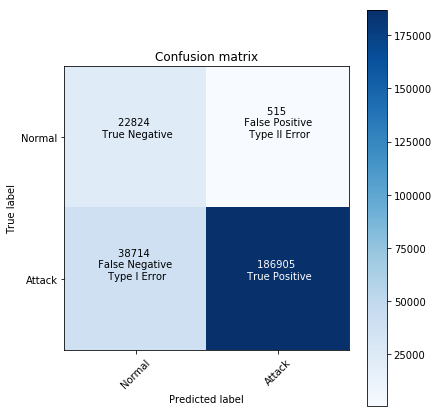

In [32]:
plot(actual_value = df.loc[:,'Actual'].values.astype(int),
     pred_value = df.loc[:,'Prediction'].values.astype(int))

In [33]:
psg.mean().sort_values(by='quality_score', ascending=False)

train_score  test_score  quality_score  \
no_of_features hidden_layers                                           
1              3                 0.710989    0.787561       0.217636   
4              1                 0.328882    0.500382       0.004359   
               3                 0.335972    0.500000       0.000000   
8              3                 0.320167    0.500000       0.000000   
16             1                 0.321321    0.500000       0.000000   
42             3                 0.319974    0.500000       0.000000   
               1                 0.324690    0.499999      -0.000037   
1              1                 0.320999    0.500000      -0.000061   
16             3                 0.435736    0.499996      -0.000092   
8              1                 0.327700    0.498130      -0.010115   

                              time_taken  
no_of_features hidden_layers              
1              3               55.044972  
4              1               50.331757  
               3               57.875265  
8              3               58.000915  
16             1               51.474659  
42             3               67.970073  
               1               52.110761  
1              1               55.379667  
16             3               60.303406  
8              1               50.228796

In [34]:
psg.std()

train_score    test_score  quality_score  \
no_of_features hidden_layers                                             
1              1                      0.0  6.960261e-07       0.000266   
               3                      0.0  9.470045e-02       0.117982   
4              1                      0.0  2.345350e-03       0.025767   
               3                      0.0  0.000000e+00       0.000000   
8              1                      0.0  8.085994e-04       0.005713   
               3                      0.0  0.000000e+00       0.000000   
16             1                      0.0  0.000000e+00       0.000000   
               3                      0.0  2.097447e-05       0.000510   
42             1                      0.0  3.811690e-06       0.000203   
               3                      0.0  0.000000e+00       0.000000   

                              time_taken  
no_of_features hidden_layers              
1              1                     0.0  
               3                     0.0  
4              1                     0.0  
               3                     0.0  
8              1                     0.0  
               3                     0.0  
16             1                     0.0  
               3                     0.0  
42             1                     0.0  
               3                     0.0

In [36]:
from scipy import stats

def fn(x):
    #print(x)
    return stats.norm.interval(0.95, loc=x.quality_score.mean(), scale=x.quality_score.std())
psg.apply(fn)

/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1907: RuntimeWarning: invalid value encountered in multiply
  lower_bound = self.a * scale + loc
/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1908: RuntimeWarning: invalid value encountered in multiply
  upper_bound = self.b * scale + loc


no_of_features  hidden_layers
1               1                (-0.000582524413279, 0.000460736563856)
                3                     (-0.0136042360783, 0.448877069061)
4               1                    (-0.0461442902724, 0.0548624077983)
                3                                             (nan, nan)
8               1                   (-0.0213126393688, 0.00108259546053)
                3                                             (nan, nan)
16              1                                             (nan, nan)
                3                 (-0.00109173671225, 0.000907053442103)
42              1                (-0.000435364764629, 0.000361716432081)
                3                                             (nan, nan)
dtype: object